# Project Setup

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score,confusion_matrix, accuracy_score,precision_recall_fscore_support, roc_curve, auc , recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC

# Data Exploration

In [2]:
df =pd.read_csv('neo_v2.csv')

In [3]:
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [4]:
len(df)

90836

In [5]:
ids=df['id']
unique_count = len(ids.unique())
unique_count

27423

certain objects appear more than once as they have orbited the Earth along the years.

In [6]:
df.columns

Index(['id', 'name', 'est_diameter_min', 'est_diameter_max',
       'relative_velocity', 'miss_distance', 'orbiting_body', 'sentry_object',
       'absolute_magnitude', 'hazardous'],
      dtype='object')

In [7]:
print(df.dtypes)

id                      int64
name                   object
est_diameter_min      float64
est_diameter_max      float64
relative_velocity     float64
miss_distance         float64
orbiting_body          object
sentry_object            bool
absolute_magnitude    float64
hazardous                bool
dtype: object


## Examining the Distribution of Values
We will now try to visualize the distribution of values in each column of our dataset to get a better understanding of the nature of the data.

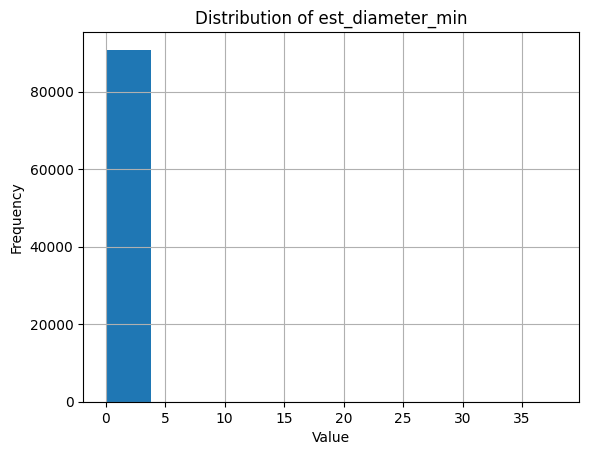

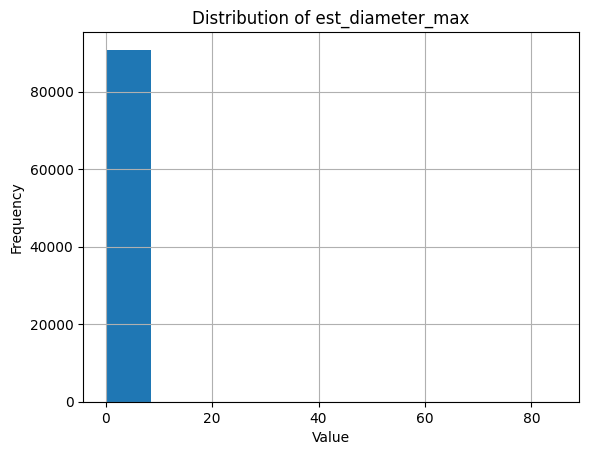

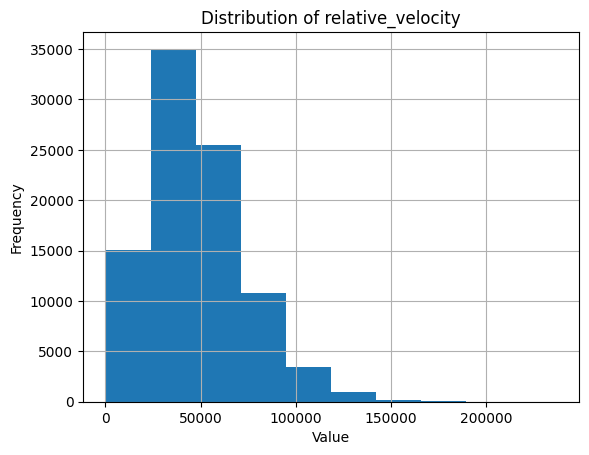

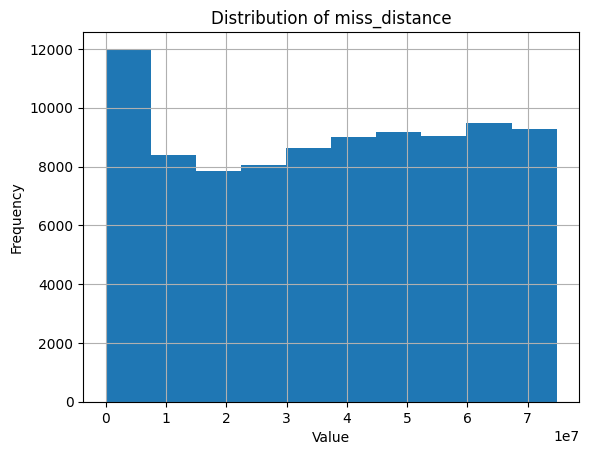

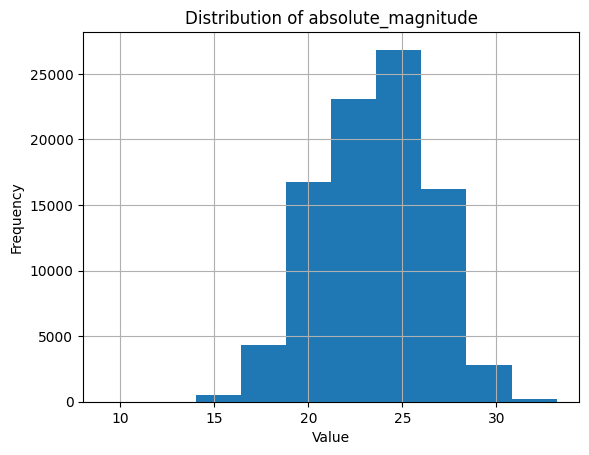

In [8]:
numerical_columns = df.select_dtypes(include=['float64']).columns
for column in numerical_columns:
    plt.figure()
    df[column].hist()
    plt.title(f'Distribution of {column}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

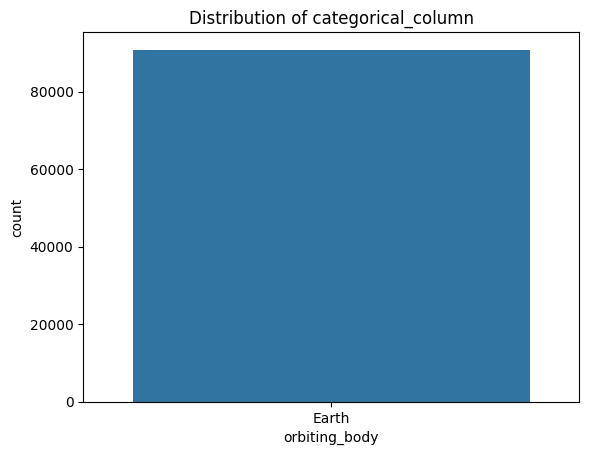

In [9]:
sns.countplot(x='orbiting_body', data=df)
plt.title('Distribution of categorical_column')
plt.show()

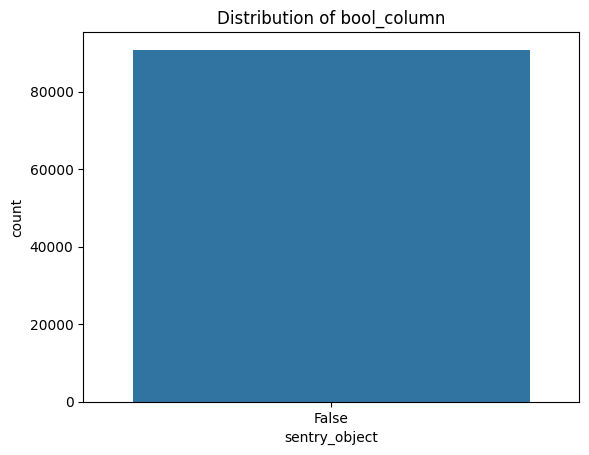

In [10]:
sns.countplot(x='sentry_object', data=df)
plt.title('Distribution of bool_column')
plt.show()


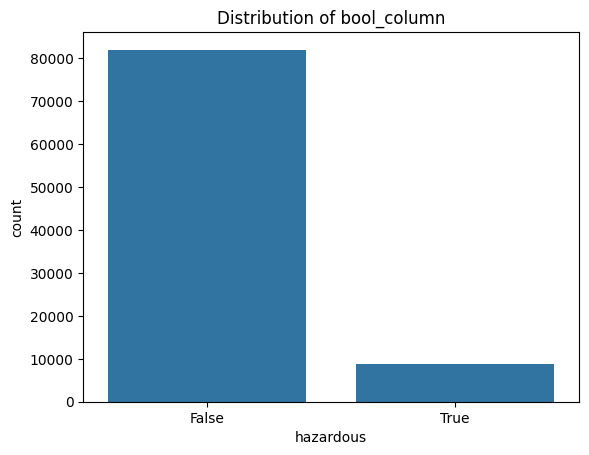

In [11]:
sns.countplot(x='hazardous', data=df)
plt.title('Distribution of bool_column')
plt.show()


Two things immediately stand out about our data; orbiting_body and sentry_object variables have no variance at all!

We also see that our data is imbalanced, as we have the non-hazardous class dominating the dataset.

## Undersampling

In [12]:
np.random.seed(420)
data_unique = df.drop_duplicates(subset='id')

hazardous_data = data_unique[data_unique['hazardous'] == True]
non_hazardous_data = data_unique[data_unique['hazardous'] == False]

hazardous_samples = len(hazardous_data)
non_hazardous_samples = len(non_hazardous_data)
final_non_hazardous_samples = min(hazardous_samples, non_hazardous_samples)

sampled_non_hazardous = non_hazardous_data.sample(n=final_non_hazardous_samples)

final_dataset = pd.concat([hazardous_data, sampled_non_hazardous])

final_dataset = final_dataset.sample(frac=1).reset_index(drop=True)


final_dataset.to_csv("balanced_dataset.csv", index=False)


# Feature Engineering

## Excluding Features

In [2]:
df=pd.read_csv('balanced_dataset.csv')
df=df.drop(['orbiting_body','id','name','sentry_object'],axis=1)
df

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,0.441118,0.986370,132493.814216,7.131359e+07,18.90,True
1,0.121494,0.271669,58390.790614,1.105746e+07,21.70,True
2,0.014607,0.032662,37532.416737,3.673074e+06,26.30,False
3,0.345585,0.772752,31037.558291,4.844980e+06,19.43,True
4,0.040230,0.089958,29615.965292,5.603759e+07,24.10,False
...,...,...,...,...,...,...
4341,0.192555,0.430566,23741.014606,6.555819e+07,20.70,False
4342,0.146068,0.326618,40916.419471,2.842237e+07,21.30,False
4343,0.038420,0.085909,45908.573721,2.800036e+07,24.20,False
4344,0.623096,1.393285,129256.666640,4.782509e+07,18.15,True


In [3]:
X = df.drop('hazardous', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Unsupervised Models

## Principal Component Analysis (PCA)

In our analysis, we have applied PCA to a dataset containing various features associated with celestial objects. These features have been standardized before applying PCA to ensure that each feature contributes equally to the analysis.

In [15]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)


pca_results = pd.DataFrame({
    'Component': ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'],
    'Standard Deviation': np.sqrt(explained_variance),
    'Proportion of Variance': explained_variance_ratio,
    'Cumulative Proportion': cumulative_variance_ratio
})

print("Importance of components:")
print(pca_results.to_string(index=False))

Importance of components:
Component  Standard Deviation  Proportion of Variance  Cumulative Proportion
      PC1        1.676054e+00            5.617023e-01               0.561702
      PC2        1.086227e+00            2.359237e-01               0.797626
      PC3        8.017945e-01            1.285453e-01               0.926171
      PC4        6.076419e-01            7.382873e-02               1.000000
      PC5        7.173382e-11            1.028911e-21               1.000000


## Clustering

### Hierarchical Clustering

In this analysis, we explored hierarchical clustering using different linkage methods on a dataset. The goal was to determine an optimal number of clusters for the data.


we performed hierarchical clustering using various linkage methods:

- **Complete Linkage:** This method uses the maximum pairwise distance between points in two clusters.
- **Single Linkage:** It considers the minimum pairwise distance between points in two clusters.
- **Average Linkage:** This method calculates the average pairwise distance between points in two clusters.
- **McQuitty Linkage:** It is a modification of the average linkage method.
- **Ward D Linkage:** This method minimizes the variance of distances within clusters.

Performing 'complete' linkage.


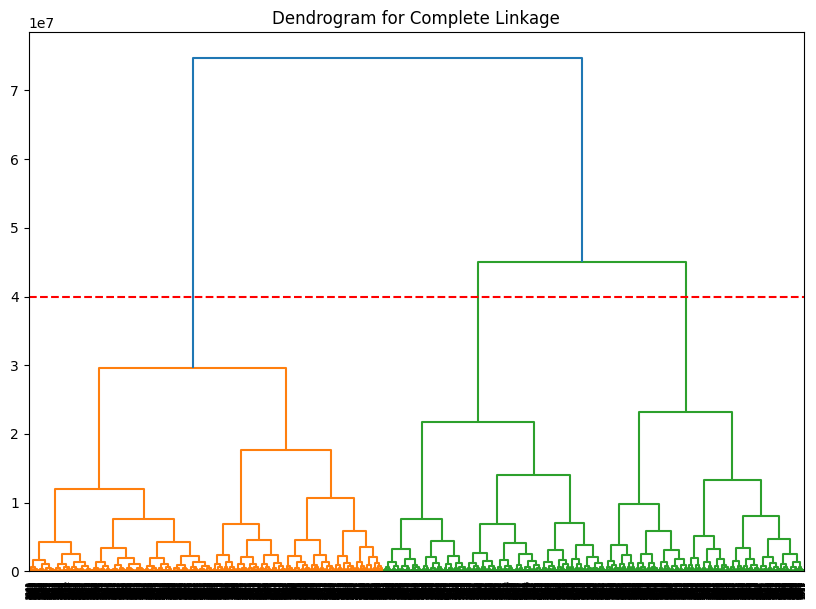

Cluster labels for complete linkage with cutoff 40000000.0:
[2 1 1 ... 1 3 2]


Performing 'single' linkage.


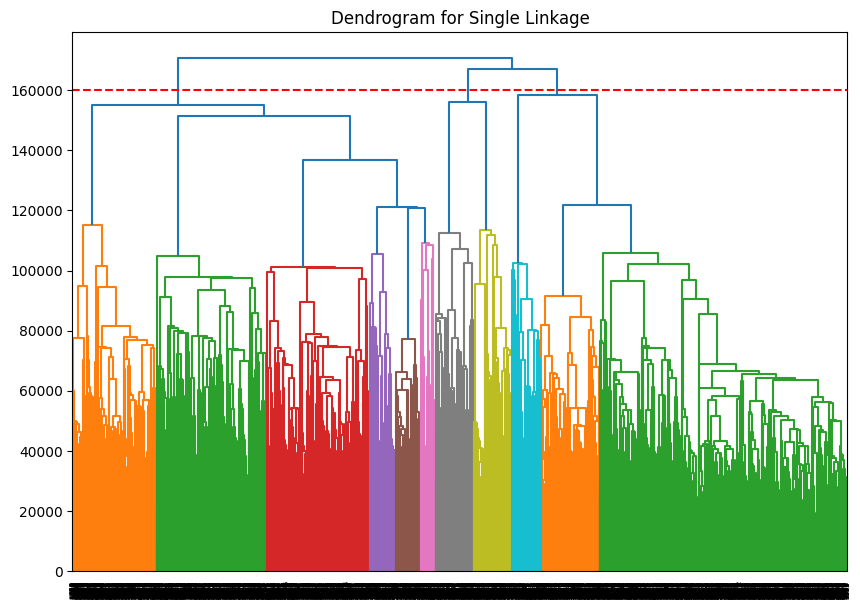

Cluster labels for single linkage with cutoff 160000:
[1 3 3 ... 2 1 1]


Performing 'average' linkage.


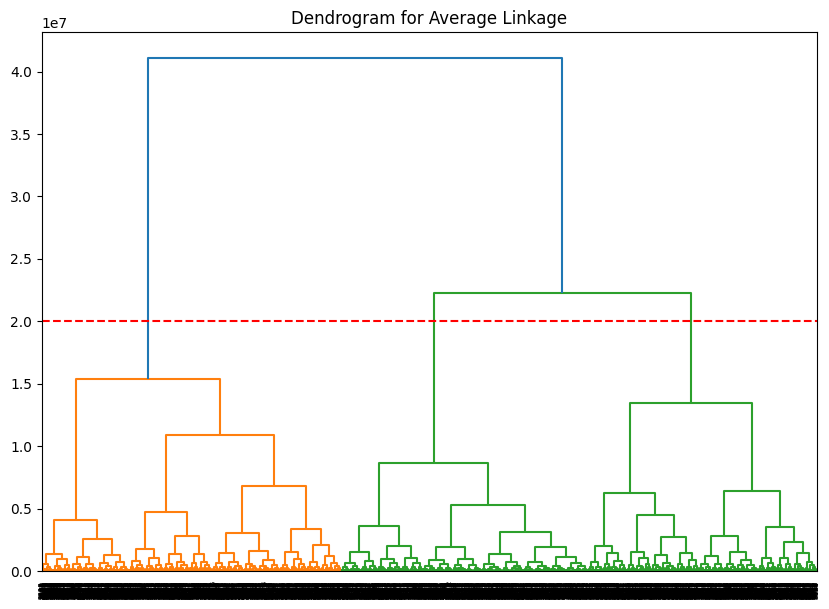

Cluster labels for average linkage with cutoff 20000000.0:
[1 2 2 ... 3 1 1]


Performing 'ward' linkage.


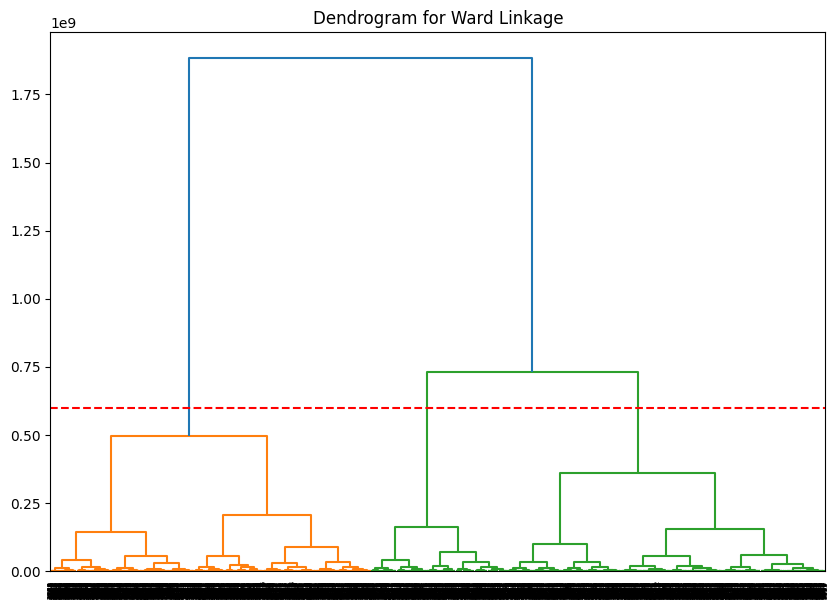

Cluster labels for ward linkage with cutoff 600000000.0:
[1 3 3 ... 2 1 1]




In [16]:
data_matrix = df.values
cutoffs = {
    'complete': 40000000.0,
    'single': 160000,
    'average': 20000000.0,
    'ward': 600000000.0, 
}


linkage_methods = ['complete', 'single', 'average', 'ward']

for method in linkage_methods:
    print(f"Performing '{method}' linkage.")
    Z = linkage(data_matrix, method=method)

    cutoff = cutoffs[method]
    cluster_labels = fcluster(Z, cutoff, criterion='distance')
    
    plt.figure(figsize=(10, 7))
    plt.title(f"Dendrogram for {method.title()} Linkage")
    dendrogram(Z)
    plt.axhline(y=cutoff, color='r', linestyle='--')
    plt.show()
    
    print(f"Cluster labels for {method} linkage with cutoff {cutoff}:")
    print(cluster_labels)
    print("\n")

## Split the Dataset

In [5]:

y = df['hazardous']
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42, stratify=y)


# Model Development

## Decision Trees
The first of a few models we will be trying is Decision Trees.


 ### Simple Model

In [18]:
clf = DecisionTreeClassifier(max_depth=2,random_state=42)
clf.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=2, random_state=42)

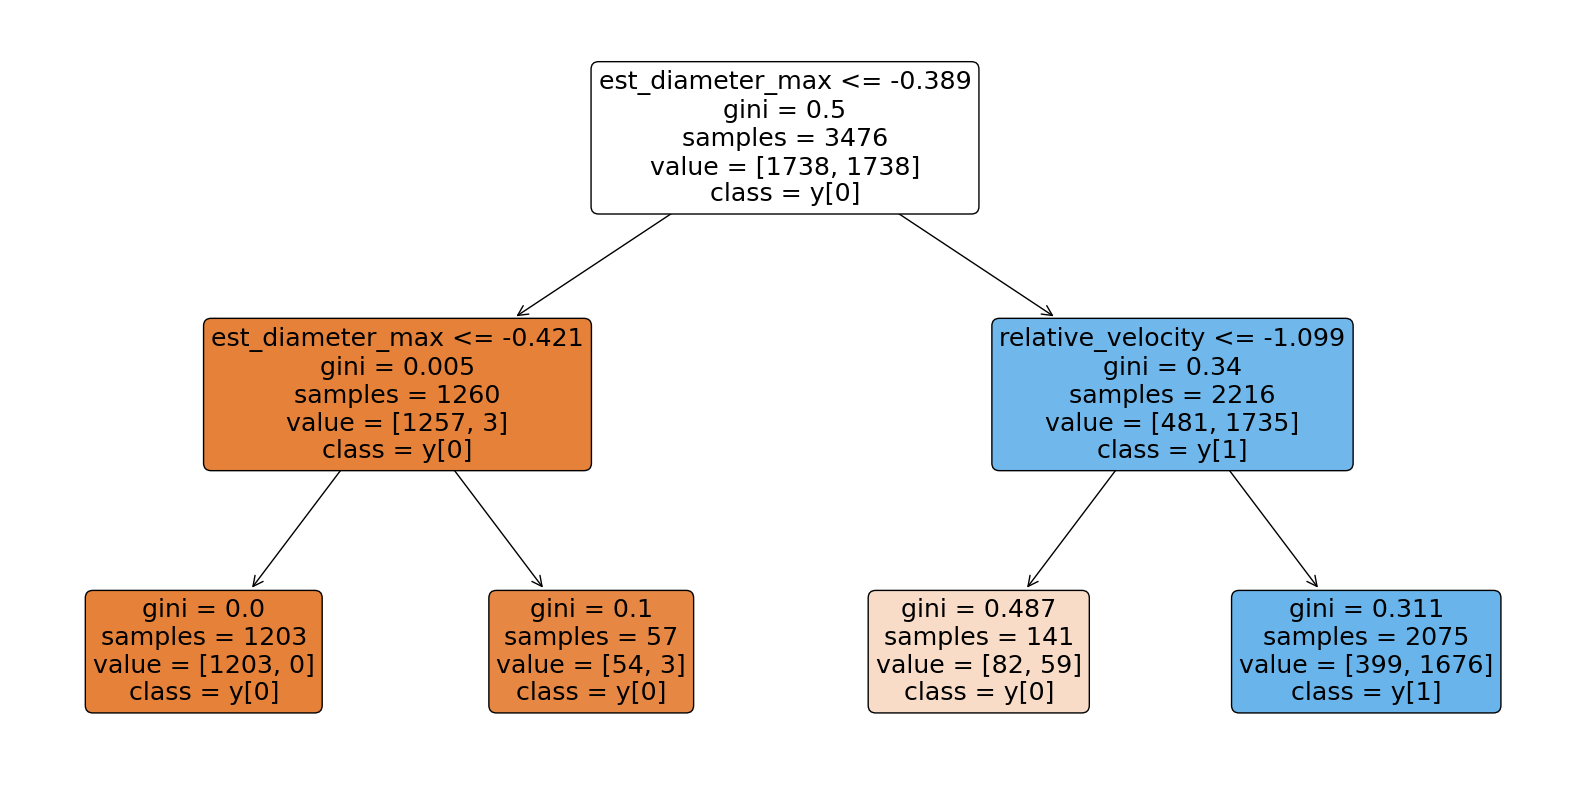

In [19]:

plt.figure(figsize=(20,10))  
plot_tree(clf, filled=True, feature_names=X.columns, class_names=True, rounded=True)
plt.show()


Balanced Accuracy: 0.86
Sensitivity (Recall): 0.97
Specificity: 0.76
F1 Score: 0.88


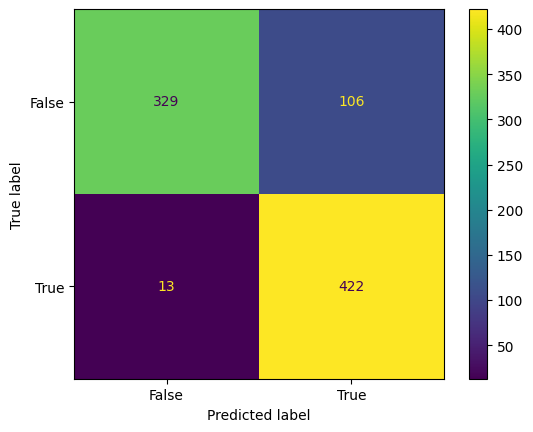

In [20]:
y_pred = clf.predict(X_test)

balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred, average='binary') 
f1 = f1_score(y_test, y_pred, average='binary')  
conf_matrix = confusion_matrix(y_test, y_pred)


tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)

print(f'Balanced Accuracy: {balanced_accuracy:.2f}')
print(f'Sensitivity (Recall): {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'F1 Score: {f1:.2f}')


ConfusionMatrixDisplay(conf_matrix, display_labels=clf.classes_).plot()
plt.show()


### Improvements
We noticed that initially, the tree is too focused on one feature, so we experimented with a few things to increase the model depth, but none of the methods we tried yielded any improvements except for increasing model complexity, with a very slight improvement in specificity as can be seen below:

In [7]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

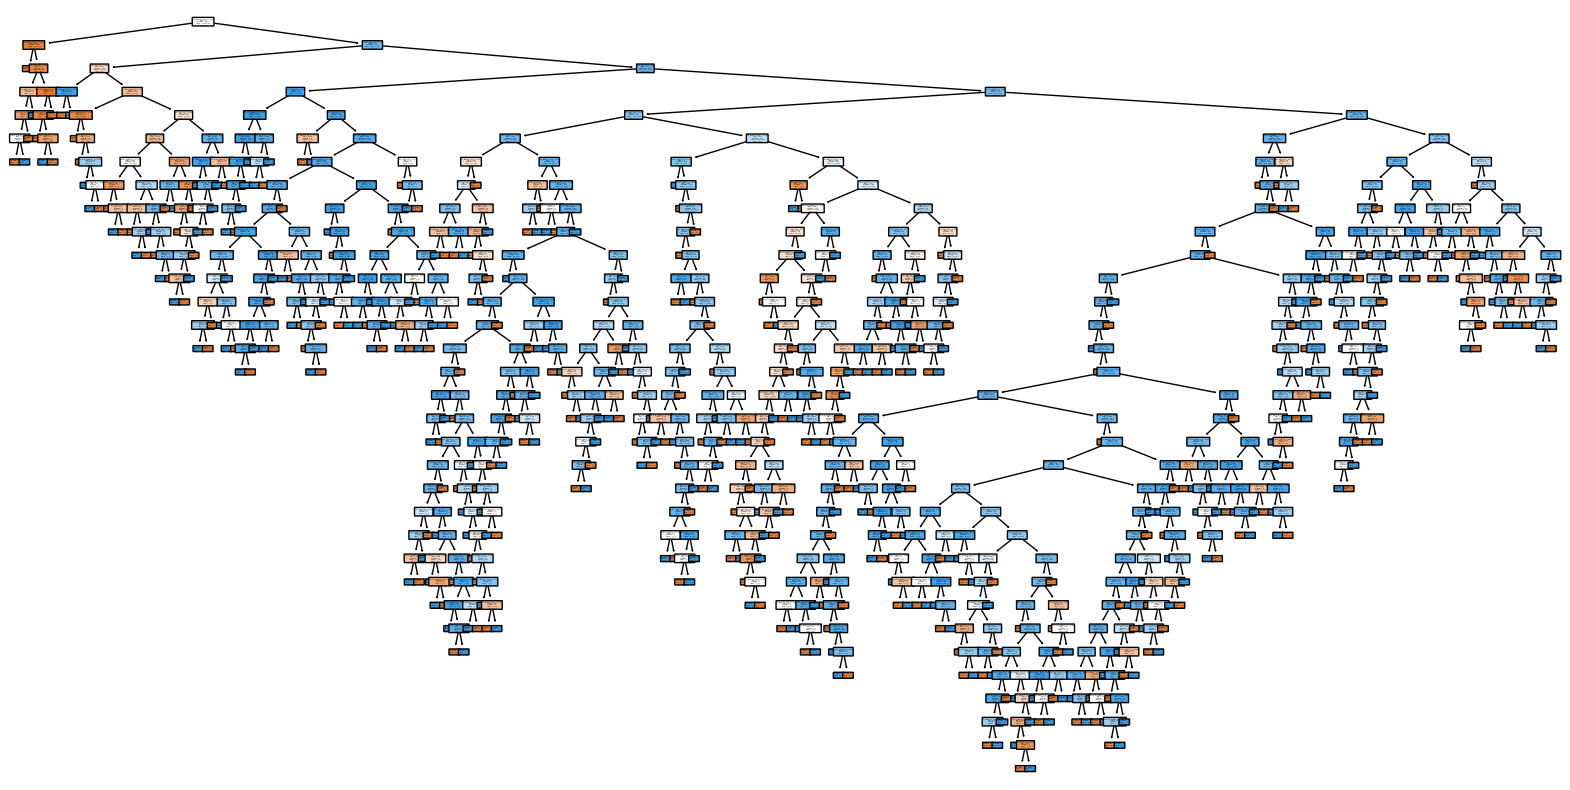

In [22]:
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=True, rounded=True)
plt.show()

Balanced Accuracy: 0.81
Sensitivity (Recall): 0.83
Specificity: 0.79
F1 Score: 0.81


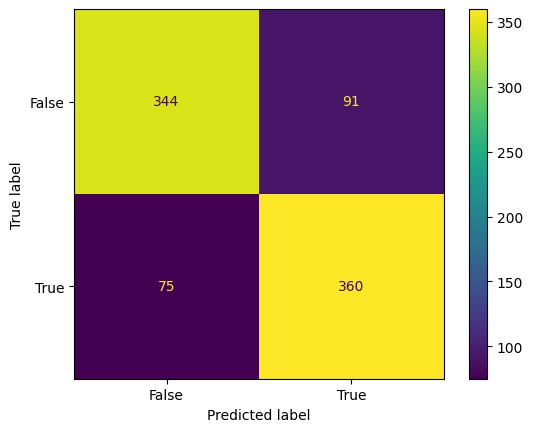

In [24]:
y_pred = clf.predict(X_test)


balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred, average='binary') 
f1 = f1_score(y_test, y_pred, average='binary') 
conf_matrix = confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)

print(f'Balanced Accuracy: {balanced_accuracy:.2f}')
print(f'Sensitivity (Recall): {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'F1 Score: {f1:.2f}')

ConfusionMatrixDisplay(conf_matrix, display_labels=clf.classes_).plot()
plt.show()

### Hyperparameter Tuning

In [9]:

depth_range = range(1, 100)
cv_scores = []

for depth in depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(np.mean(scores)) 

optimal_depth = depth_range[np.argmax(cv_scores)]
print(f'Optimal Depth: {optimal_depth}')


Optimal Depth: 4


In [27]:
clf = DecisionTreeClassifier(max_depth=4,random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

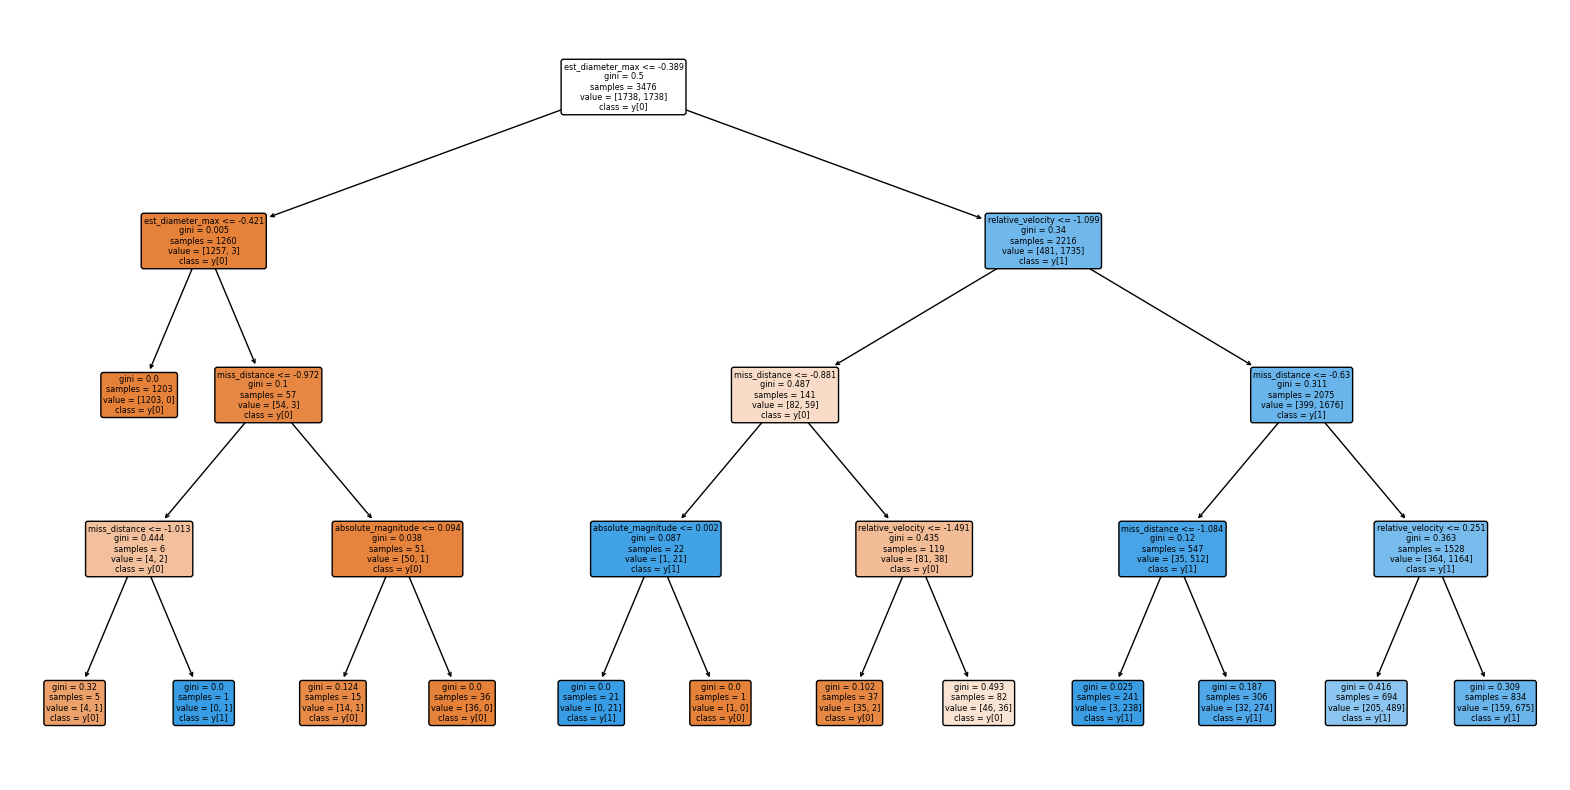

In [28]:
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=True, rounded=True)
plt.show()

Balanced Accuracy: 0.87
Sensitivity (Recall): 0.98
Specificity: 0.76
F1 Score: 0.88


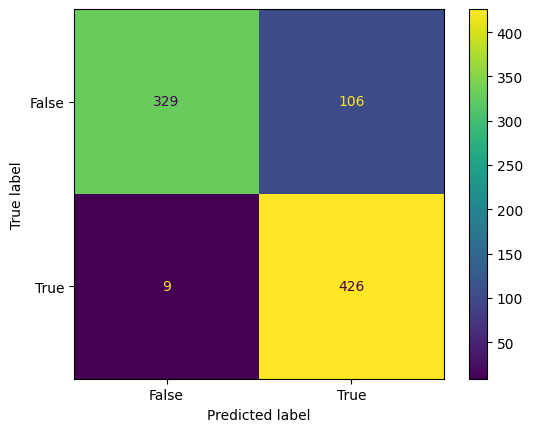

In [30]:
y_pred = clf.predict(X_test)


balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred, average='binary') 
f1 = f1_score(y_test, y_pred, average='binary')
conf_matrix = confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)

print(f'Balanced Accuracy: {balanced_accuracy:.2f}')
print(f'Sensitivity (Recall): {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'F1 Score: {f1:.2f}')


ConfusionMatrixDisplay(conf_matrix, display_labels=clf.classes_).plot()
plt.show()

## Random Forest

We tried a random forests approach, which is a collection of decision trees. We were able to use the same data from the decision trees, so first we define the model:

In [31]:

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)


rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

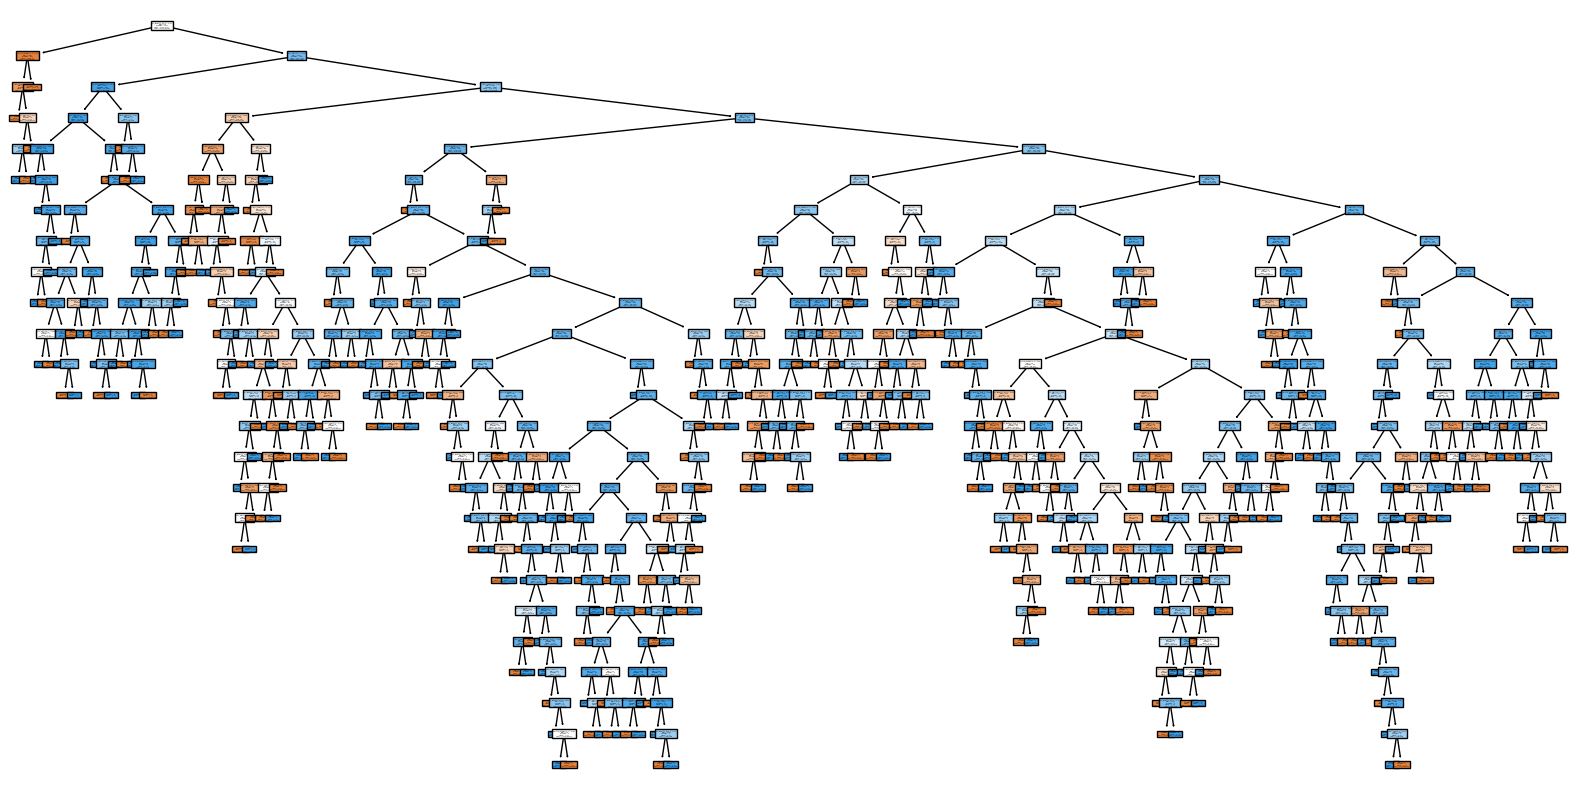

In [125]:
plt.figure(figsize=(20, 10))
plot_tree(rf_classifier.estimators_[0], filled=True, feature_names=X.columns, class_names=['non-hazardous', 'hazardous'])
plt.show()

Balanced Accuracy: 0.86
Sensitivity (Recall): 0.92
Specificity: 0.79
F1 Score: 0.87


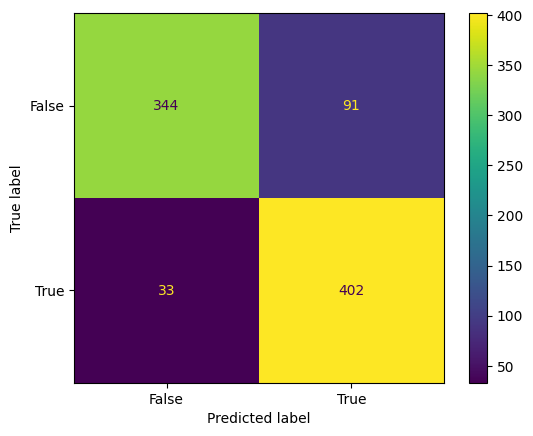

In [33]:
y_pred =rf_classifier.predict(X_test)


balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary') 
conf_matrix = confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)

print(f'Balanced Accuracy: {balanced_accuracy:.2f}')
print(f'Sensitivity (Recall): {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'F1 Score: {f1:.2f}')

ConfusionMatrixDisplay(conf_matrix, display_labels=clf.classes_).plot()
plt.show()

### Decision Tree with PCA
We test the simple decision tree on a different number of components and getting the results

Accuracy with 1 components: 0.8069
Accuracy with 2 components: 0.8506
Accuracy with 3 components: 0.8621
Accuracy with 4 components: 0.8586
Accuracy with 5 components: 0.8586


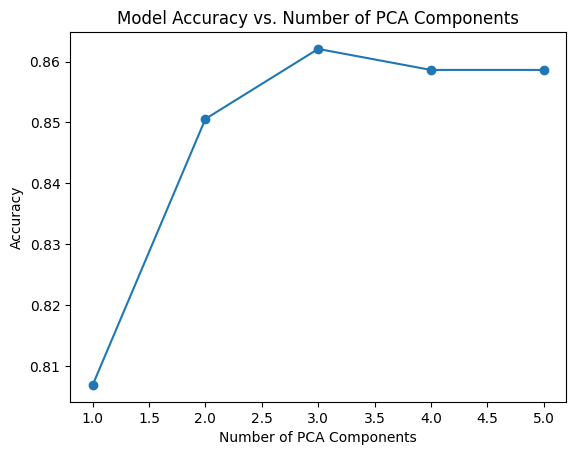

In [34]:
components_range = range(1, 6)  
accuracies = []

for n_components in components_range:
   
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    clf = DecisionTreeClassifier(max_depth=4,random_state=42)
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Accuracy with {n_components} components: {accuracy:.4f}")


plt.plot(components_range, accuracies, marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. Number of PCA Components')
plt.show()


## SVM
The SVM model is fitted using different kernels: linear, polynomial, radial, and sigmoid.

In [35]:

kernels = ['linear','poly', 'rbf', 'sigmoid']
results_list = []
roc_data_list = []  

for kernel in kernels:
    model = SVC(kernel=kernel, probability=True, random_state=42)
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)

    cm = confusion_matrix(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, predictions, average='binary')

    probabilities = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    auc_value = auc(fpr, tpr)

    results_list.append({'Kernel': kernel, 'Accuracy': accuracy, 'F1 Score': f1_score, 'AUC': auc_value})
    kernel_roc_data = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Thresholds': thresholds, 'Kernel': kernel})
    roc_data_list.append(kernel_roc_data)

results = pd.DataFrame(results_list)

roc_data = pd.concat(roc_data_list, ignore_index=True)

print(results)


    Kernel  Accuracy  F1 Score       AUC
0   linear  0.837931  0.853278  0.876694
1     poly  0.816092  0.840954  0.876951
2      rbf  0.859770  0.874227  0.912818
3  sigmoid  0.740230  0.730952  0.811949


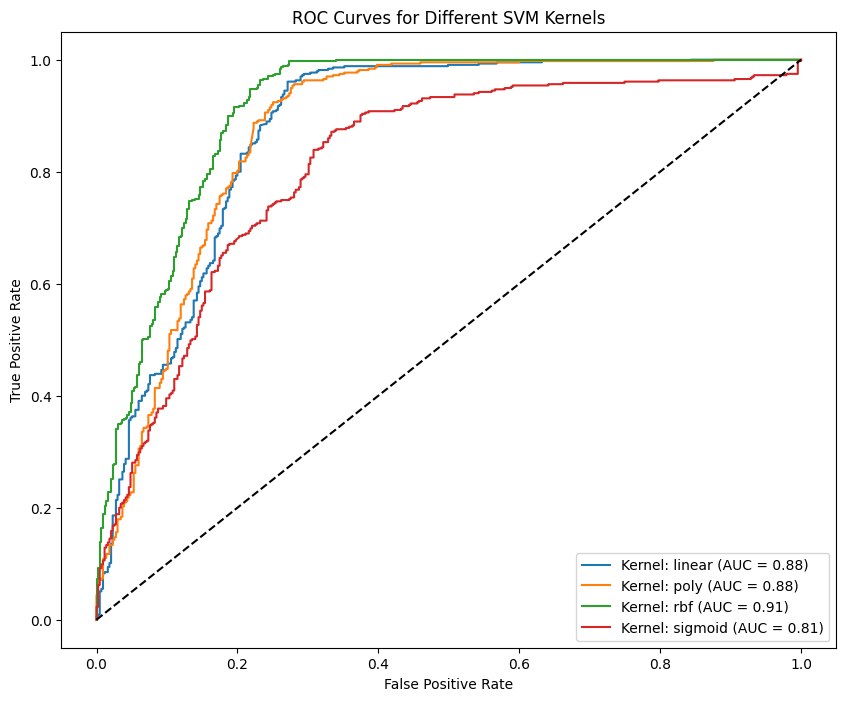

In [36]:

plt.figure(figsize=(10, 8))

for i in range(len(roc_data_list)):
    plt.plot(roc_data_list[i]['FPR'], roc_data_list[i]['TPR'], label=f'Kernel: {kernels[i]} (AUC = {results["AUC"][i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different SVM Kernels')
plt.legend(loc='lower right')
plt.show()

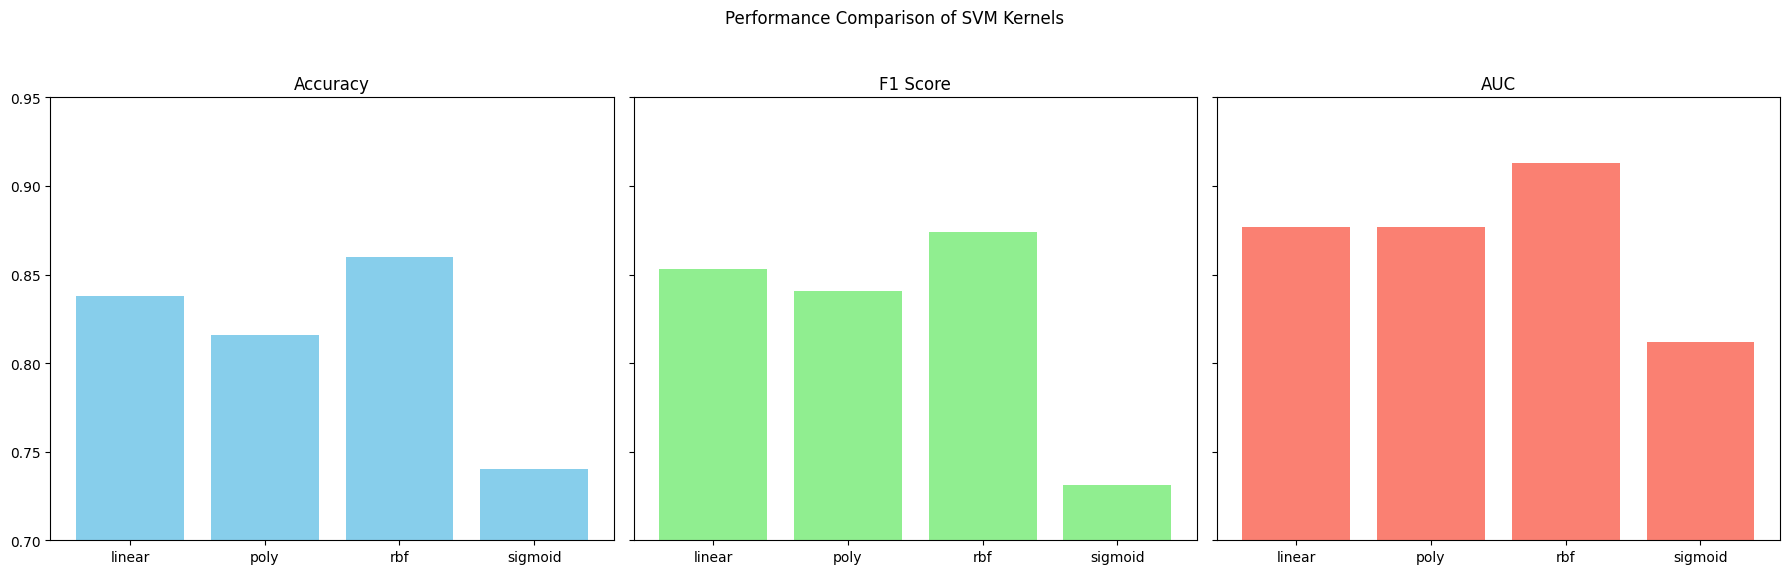

In [37]:

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Performance Comparison of SVM Kernels')

# Accuracy
axes[0].bar(results['Kernel'], results['Accuracy'], color='skyblue')
axes[0].set_title('Accuracy')
axes[0].set_ylim(0.7, 0.95)

# F1 Score
axes[1].bar(results['Kernel'], results['F1 Score'], color='lightgreen')
axes[1].set_title('F1 Score')
axes[1].set_ylim(0.7, 0.95)

# AUC
axes[2].bar(results['Kernel'], results['AUC'], color='salmon')
axes[2].set_title('AUC')
axes[2].set_ylim(0.7, 0.95)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()